## Exploración y entendimiento profundo de los datos ##

Librerias:

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Datos:

In [74]:
PATH = "C:/Users/pauli/Documents/MetodosGranEscala/Prediccion_de-_demanda_en_retail/Data/"
#PATH = "/Users/monserratarredondo/GitHub/Prediccion_de-_demanda_en_retail/Data/"

item_categories = pd.read_csv(PATH + "item_categories.csv", encoding='utf-8', low_memory=False)
items= pd.read_csv(PATH + "items.csv", encoding='utf-8', low_memory=False)
sales_train = pd.read_csv(PATH + "sales_train.csv", encoding='utf-8', low_memory=False)
sample_submission = pd.read_csv(PATH + "sample_submission.csv", encoding='utf-8', low_memory=False)
shops = pd.read_csv(PATH + "shops.csv", encoding='utf-8', low_memory=False)
test = pd.read_csv(PATH + "test.csv", encoding='utf-8', low_memory=False)

In [75]:
item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [76]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID              214200 non-null  int64  
 1   item_cnt_month  214200 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 3.3 MB


In [77]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [78]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


*Exploración sobre datos históricos de ventas diarias (2013-2015)*

In [79]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [80]:
sales_train.head(3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0
2,05.01.2013,0,25,2552,899.0,-1.0


*Combinaciones producto-tienda para predicción*

In [81]:
test.head(3)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233


*Información de productos y categorías*

In [82]:
items.head(3)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40


Objetivo

- item_cnt_month = suma de item_cnt_day por (date_block_num, shop_id, item_id)

Predictoras base

- Identificadores: shop_id, item_id, date_block_num (mes)
- Precio: item_price 
- Info del producto: item_category_id 
- Info de tienda: shop_name 

Base limpia

In [83]:
sales = sales_train.copy()

# Fecha a datetime (en este dataset viene como "dd.mm.yyyy")
sales["date"] = pd.to_datetime(sales["date"], format="%d.%m.%Y", errors="coerce")

# Limpieza rápida: evita precios raros y devoluciones si no las quieres en este baseline
sales = sales[(sales["item_price"] > 0) & (sales["item_cnt_day"] >= 0)].copy()

# Ingreso diario
sales["revenue_day"] = sales["item_price"] * sales["item_cnt_day"]

print("Rango fechas:", sales["date"].min(), "→", sales["date"].max())
print("Nulos en date:", sales["date"].isna().sum())
print("Filas después de limpiar:", len(sales))


Rango fechas: 2013-01-01 00:00:00 → 2015-10-31 00:00:00
Nulos en date: 0
Filas después de limpiar: 2928492


Tabla mensual con grid

In [84]:
# 1) Agregado mensual observado
monthly_sales = (
    sales.groupby(["date_block_num", "shop_id", "item_id"], as_index=False)
    .agg(
        item_cnt_month=("item_cnt_day", "sum"),     # target
        item_price_mean=("item_price", "mean"),
        revenue_month=("revenue_day", "sum"),
        days_obs=("date", "nunique"),
    )
)

# 2) Grid mensual: todos los pares (shop_id, item_id) que existieron en ese mes
monthly_pairs = sales[["date_block_num", "shop_id", "item_id"]].drop_duplicates()

# 3) Merge para meter ceros donde no hubo venta
monthly = monthly_pairs.merge(
    monthly_sales,
    on=["date_block_num", "shop_id", "item_id"],
    how="left"
)

monthly["item_cnt_month"] = monthly["item_cnt_month"].fillna(0).astype(np.float32)
monthly["item_price_mean"] = monthly["item_price_mean"].fillna(0).astype(np.float32)
monthly["revenue_month"] = monthly["revenue_month"].fillna(0).astype(np.float32)
monthly["days_obs"] = monthly["days_obs"].fillna(0).astype(np.int16)

# Enriquecer con categoría (para EDA y luego features)
monthly = monthly.merge(items[["item_id", "item_category_id"]], on="item_id", how="left")

print("Shape monthly:", monthly.shape)
print("Proporción de ceros:", (monthly["item_cnt_month"] == 0).mean().round(4))
monthly.head()


Shape monthly: (1608226, 8)
Proporción de ceros: 0.0


,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,revenue_month,days_obs,item_category_id
0,0,59,22154,1.0,999.000000,999.000000,1,37
1,0,25,2552,1.0,899.000000,899.000000,1,58
2,0,25,2554,1.0,1709.050049,1709.050049,1,58
3,0,25,2555,1.0,1099.000000,1099.000000,1,56
4,0,25,2564,1.0,349.000000,349.000000,1,59


Sanity check del target

count    1.608226e+06
mean     2.273154e+00
std      8.653235e+00
min      1.000000e+00
50%      1.000000e+00
90%      4.000000e+00
95%      6.000000e+00
99%      1.700000e+01
max      2.253000e+03
Name: item_cnt_month, dtype: float64
Mes-producto-tienda con 0 ventas: 0.0


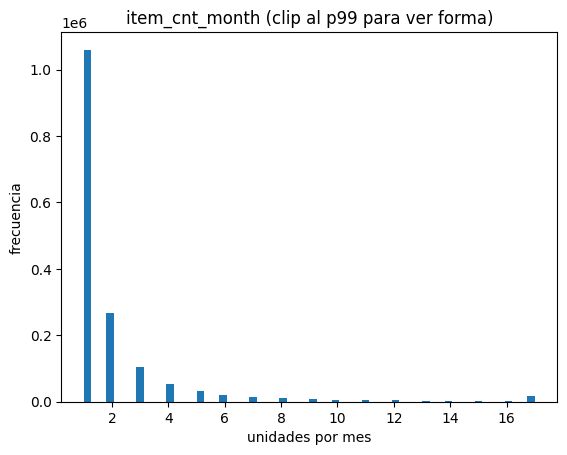

In [85]:
y = monthly["item_cnt_month"]

print(y.describe(percentiles=[.5, .9, .95, .99]))
print("Mes-producto-tienda con 0 ventas:", (y == 0).mean().round(4))

# Histograma (clip al p99 para que se vea la forma sin que aplaste todo)
p99 = y.quantile(0.99)

plt.figure()
plt.hist(y.clip(upper=p99), bins=60)
plt.title("item_cnt_month (clip al p99 para ver forma)")
plt.xlabel("unidades por mes")
plt.ylabel("frecuencia")
plt.show()


Patrón temporal global (estacionalidad / cambios fuertes)

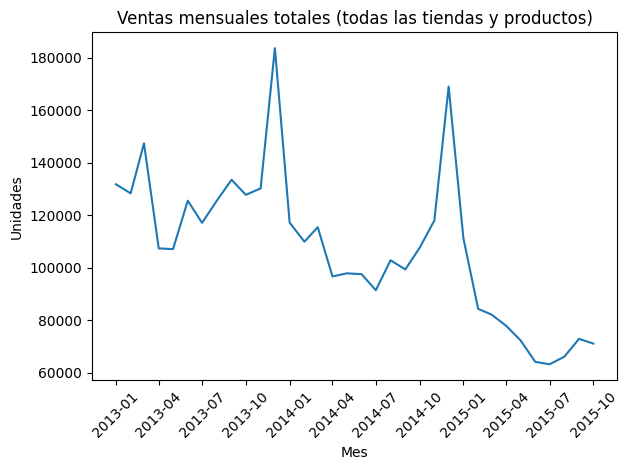

Mes con más unidades: 2013-12 -> 183670.0
Mes con menos unidades: 2015-07 -> 63316.0


In [88]:
ts = monthly.groupby("date_block_num", as_index=False)["item_cnt_month"].sum()
ts["date_block_num"] = ts["date_block_num"].astype(int)

# 0 = 2013-01, 1 = 2013-02, ...
max_block = ts["date_block_num"].max()
month_map = pd.Series(
    pd.date_range("2013-01-01", periods=max_block + 1, freq="MS"),
    index=range(max_block + 1)
)

ts["month_dt"] = ts["date_block_num"].map(month_map)           # datetime64
ts["month"] = ts["month_dt"].dt.strftime("%Y-%m")              # etiqueta

plt.figure()
plt.plot(ts["month_dt"], ts["item_cnt_month"])
plt.title("Ventas mensuales totales (todas las tiendas y productos)")
plt.xlabel("Mes")
plt.ylabel("Unidades")

# etiqueta cada 3 meses para que no se encime
ticks = ts["month_dt"].iloc[::3]
plt.xticks(ticks, [d.strftime("%Y-%m") for d in ticks], rotation=45)

plt.tight_layout()
plt.show()

max_row = ts.loc[ts["item_cnt_month"].idxmax()]
min_row = ts.loc[ts["item_cnt_month"].idxmin()]

print("Mes con más unidades:", max_row["month"], "->", float(max_row["item_cnt_month"]))
print("Mes con menos unidades:", min_row["month"], "->", float(min_row["item_cnt_month"]))


¿Quién carga el volumen? (top tiendas / top categorías)

In [ ]:
top_shops = (
    monthly.groupby("shop_id")["item_cnt_month"].sum()
    .sort_values(ascending=False)
    .head(10)
)
print("Top 10 tiendas por unidades:")
print(top_shops)

top_cats = (
    monthly.groupby("item_category_id")["item_cnt_month"].sum()
    .sort_values(ascending=False)
    .head(10)
)
print("\nTop 10 categorías por unidades:")
print(top_cats)


Top 10 tiendas por unidades:
shop_id
31    311230.0
25    242237.0
54    186149.0
28    184777.0
42    145195.0
57    141424.0
27    136815.0
6     100757.0
58     81908.0
46     79092.0
Name: item_cnt_month, dtype: float32

Top 10 categorías por unidades:
item_category_id
40    634885.0
30    457359.0
55    349050.0
19    255756.0
37    204031.0
71    188016.0
28    175227.0
23    170577.0
20    127763.0
65     73103.0
Name: item_cnt_month, dtype: float32


ver si el volumen está súper concentrado en pocos IDs

In [ ]:
shop_share = top_shops.sum() / monthly["item_cnt_month"].sum()
cat_share = top_cats.sum() / monthly["item_cnt_month"].sum()

print("\n% de unidades explicadas por Top 10 tiendas:", round(shop_share * 100, 2), "%")
print("% de unidades explicadas por Top 10 categorías:", round(cat_share * 100, 2), "%")


% de unidades explicadas por Top 10 tiendas: 44.03 %
% de unidades explicadas por Top 10 categorías: 72.1 %


Precio vs demanda

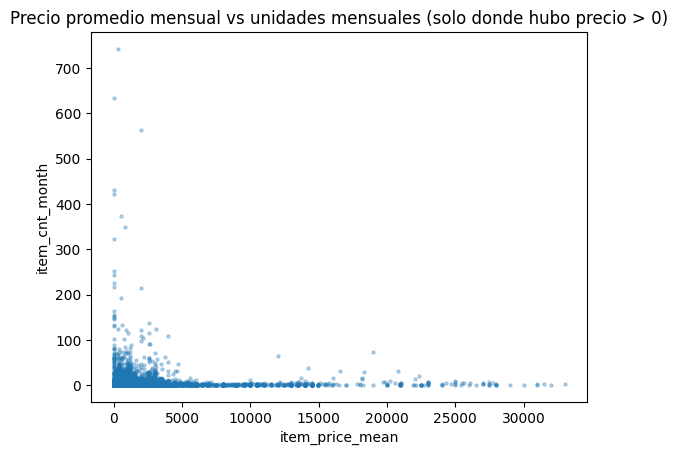

Corr (Spearman) precio vs demanda: 0.158


In [ ]:
valid = monthly[monthly["item_price_mean"] > 0].copy()

# Si es enorme, muestreamos
sample = valid.sample(50000, random_state=42) if len(valid) > 50000 else valid

plt.figure()
plt.scatter(sample["item_price_mean"], sample["item_cnt_month"], s=5, alpha=0.3)
plt.title("Precio promedio mensual vs unidades mensuales (solo donde hubo precio > 0)")
plt.xlabel("item_price_mean")
plt.ylabel("item_cnt_month")
plt.show()

corr_spear = sample[["item_price_mean", "item_cnt_month"]].corr(method="spearman").iloc[0, 1]
print("Corr (Spearman) precio vs demanda:", round(float(corr_spear), 3))


Revisión rápida de cobertura vs test

In [ ]:
train_pairs = monthly[["shop_id", "item_id"]].drop_duplicates()
test_pairs = test[["shop_id", "item_id"]].drop_duplicates()

covered = test_pairs.merge(train_pairs, on=["shop_id", "item_id"], how="left", indicator=True)
print("Pares en test:", len(test_pairs))
print("Pares vistos en train:", (covered["_merge"] == "both").sum())
print("Pares NO vistos en train:", (covered["_merge"] != "both").sum())

Pares en test: 214200
Pares vistos en train: 111404
Pares NO vistos en train: 102796
